# Project Report: Predicting Usage of a Video Game Research Server
By: Deepika Ramola
### Introduction
A group of computer science (CS) students at UBC is interested in understanding how people play video games. For there data analysis, they set up a server running MineCraft and recorded play sessions for each player. Minecraft was created in 2009 by Zachary Barth. Some researcher are interested in understanding the educational benefit of games like MineCraft. Nebel et el. found in there literature review that MineCraft can be used to teach topics ranging from geometry and chemistry to language, storytelling, and AI (2015). It encourages creativity, self-directed learning, and collaboration in players. 

Running the server, however, is not easy and the CS students want to answer multiple predictive and exploratory questions using the data collected. One such question is "When do the most players tend to play?"

Thus, my question is, can we use hours and days of the week to predict whether there is a high demand (large number of players playing at the same time)? 

I am using the players.csv and sessions.csv datasets provided by CS students.

For player.csv:
* experience: players experience level in the game (pro, veteran, amateur, beginner and regular)
* Age: age
* gender: gender (Female, Male, Non-binary, Prefer not to say, Agender, Two-Spirited and Other)
* subscribe: subscirbed for Minecraft server (TRUE/FALSE)
* hashedEmail: hashed version of email address for each player
* played_hours: number of hours played by each player
* name: player name

For sessions.csv:
* hashedEmail: hashed version of email address for each player
* start_time: game start time for each player with in date/month/year hour/min format
* end_time: game end time for each player with in date/month/year hour/min format
* original_start_time: timestamps recorded in Unix time format for game start time, specifically in milliseconds since the Unix epoch
* original_end_time: timestamps recorded in Unix time format for game end time, specifically in milliseconds since the Unix epoch

Based on the list above, we will convert start_time and end_time to actual datetime objects rather than a character,and then find out the total number of hours and day of the week. Then we will use hour to predict demand for the server during particular hours of the day.  

I used k-nn classification model because the question is a classification task. We are trying to predict a categorical outcome:
High demand vs. Low demand (binary). K-NN is a supervised classification algorithm and it works well for this type of problem.

Limitation: Sensitive to Feature Scaling: k-NN uses distance metrics (Euclidean distance), so we need to standardize the predictor (hour).

Methods
Preprocessing and exploratory data analysis
Imported libraries and processed session.csv and players.csv

Cleaned and tidied data to make it usable, by assigning column types and adding new columns.

Split the data into training and testing sets, working only with the training set until the very end.

Summarized the training set to make predictions about how we want our classifier to work.

Visualized the relationship between hours and high demand to get a deeper understanding of how the data is distributed.

Finding the best value
Our goal is to find the best value for the 
-nearest neighbours, providing the highest accuracy in predictions. In the code below, we create a classifier and perform cross-validation to split the training data, train the model with one set and use the other to evaluate it because we can not use testing data. Our next steps are:

Use the recipe function to center and scale the data.

Perform cross-validation with ten folds, using vfold_cv, on the training data. I use ten folds because if we only split the data once, the results strongly depend on the observations that end up being in the validation set, so using more folds increases the accuracy.

Create a 
-nearest model with neighbours = tune() instead of a value to find the best value K.

Add the recipe and model to a workflow, using tune_grid to fit. This worfklow runs cross validation on a range of 
-nearest neighbours values that is specified in gridvals.

Find the best value by filtering for accuracy and plotting a line plot with the accuracy estimate on the y-axis and neighbours on the x-axis.

Ensure that the model does not underfit or overfit, and is more accurate than a majority classifier, using our new cross-validation results and performance metrics (e.g., accuracy, precision, recall) across a range of k values. Evaluate test accuracy and compare it to baseline performance..

Visualizing our results
To visualize our results, we plotted max  on the x-axis and cholesterol levels on the y-axis, using diagnosis to colour the points.

To check for over/underfitting, we coloured the background of the graph based on what prediction would be made at every possible point. This also allowed us to quickly identify how the model classified patients, and where the boundaries were.

Testing our classifier: made a new model specification for the best value chosen, combined with the recipe made earlier in a workflow, and fit the classifier to our training set.

Used predict on the testing set to evaluate the classifier's predicition accuracy on data it hadn't seen before.

Calculated precision and recall and produced a confusion matrix to get a sense of which diagnoses the classifier was more accurate at giving, and what effects that has on real world application.


In [1]:
# importing libraries
library(tidyverse)
library(tidymodels)
library(repr)
library(RColorBrewer)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

Read the player.csv and sessions.csv files

In [2]:
set.seed(2)
sessions <- read_csv("data/sessions.csv")
players <- read_csv("data/players.csv")

# Quick look
glimpse(sessions)
glimpse(players)

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 1,535
Columns: 5
$ hashedEmail         <chr> "bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8a…
$ start_time          <chr> "30/06/2024 18:12", "17/06/2024 23:33", "25/07/202…
$ end_time            <chr> "30/06/2024 18:24", "17/06/2024 23:46", "25/07/202…
$ original_start_time <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+12…
$ original_end_time   <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+12…
Rows: 196
Columns: 7
$ experience   <chr> "Pro", "Veteran", "Veteran", "Amateur", "Regular", "Amate…
$ subscribe    <lgl> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALSE, TRUE, T…
$ hashedEmail  <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8…
$ played_hours <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.6, 0…
$ name         <chr> "Morgan", "Christian", "Blake", "Flora", "Kylie", "Adrian…
$ gender       <chr> "Male", "Male", "Male", "Female", "Male", "Female", "Fema…
$ Age          <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 17, 22, 23, 17, 25, 22, 

Combine the two datasets and convert the start_time and end_time into datetime format.

In [3]:
full_data <- sessions |>
  left_join(players, by = "hashedEmail")

full_data <- full_data |>
    mutate(session_start = dmy_hm(start_time),
         session_end = dmy_hm(end_time))

full_data <- full_data |>
  mutate(duration_mins = as.numeric(difftime(session_end, session_start, units = "mins")))

glimpse(full_data)

Rows: 1,535
Columns: 14
$ hashedEmail         <chr> "bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8a…
$ start_time          <chr> "30/06/2024 18:12", "17/06/2024 23:33", "25/07/202…
$ end_time            <chr> "30/06/2024 18:24", "17/06/2024 23:46", "25/07/202…
$ original_start_time <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+12…
$ original_end_time   <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+12…
$ experience          <chr> "Regular", "Amateur", "Amateur", "Regular", "Amate…
$ subscribe           <lgl> TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TR…
$ played_hours        <dbl> 223.1, 53.9, 150.0, 223.1, 53.9, 223.1, 56.1, 178.…
$ name                <chr> "Hiroshi", "Alex", "Delara", "Hiroshi", "Alex", "H…
$ gender              <chr> "Male", "Male", "Female", "Male", "Male", "Male", …
$ Age                 <dbl> 17, 17, 16, 17, 17, 17, 23, 19, 27, 17, 23, 16, 10…
$ session_start       <dttm> 2024-06-30 18:12:00, 2024-06-17 23:33:00, 2024-07…
$ session_end   

Create two new column for hours and day of the week using session_start.

In [4]:
full_data <- full_data |>
  mutate(hour = hour(session_start),
         wday = wday(session_start, label = TRUE))
head(full_data)

hashedEmail,start_time,end_time,original_start_time,original_end_time,experience,subscribe,played_hours,name,gender,Age,session_start,session_end,duration_mins,hour,wday
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<lgl>,<dbl>,<chr>,<chr>,<dbl>,<dttm>,<dttm>,<dbl>,<int>,<ord>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12,Regular,TRUE,223.1,Hiroshi,Male,17,2024-06-30 18:12:00,2024-06-30 18:24:00,12,18,Sun
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12,Amateur,TRUE,53.9,Alex,Male,17,2024-06-17 23:33:00,2024-06-17 23:46:00,13,23,Mon
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12,Amateur,TRUE,150.0,Delara,Female,16,2024-07-25 17:34:00,2024-07-25 17:57:00,23,17,Thu
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12,Regular,TRUE,223.1,Hiroshi,Male,17,2024-07-25 03:22:00,2024-07-25 03:58:00,36,3,Thu
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12,Amateur,TRUE,53.9,Alex,Male,17,2024-05-25 16:01:00,2024-05-25 16:12:00,11,16,Sat
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12,Regular,TRUE,223.1,Hiroshi,Male,17,2024-06-23 15:08:00,2024-06-23 17:10:00,122,15,Sun


Since I am doing demand forecasting: Create labels like high-demand (1) / low-demand (0).

In [5]:
full_data_summary <- full_data |>
  group_by(hour, wday) |>
  summarise(player_count = n(), .groups = "drop") 

threshold <- full_data_summary |>
  pull(player_count) |>
  quantile(0.75)

full_data_summary <- full_data_summary |>
  mutate(high_demand = ifelse(player_count > threshold, 1, 0))

tail(full_data_summary)

hour,wday,player_count,high_demand
<int>,<ord>,<int>,<dbl>
23,Mon,29,1
23,Tue,12,0
23,Wed,22,1
23,Thu,14,0
23,Fri,11,0
23,Sat,19,1


We need to change wday to a numerical value because classification uses numeric predictors.

In [6]:
data_summary <- full_data_summary |>
    mutate(wday_num = as.numeric(wday)) |>
    select(hour, wday_num, high_demand)
tail(data_summary)

hour,wday_num,high_demand
<int>,<dbl>,<dbl>
23,2,1
23,3,0
23,4,1
23,5,0
23,6,0
23,7,1


Create a visualization of the data, with hour on x-axis and avg_demand on y-axis

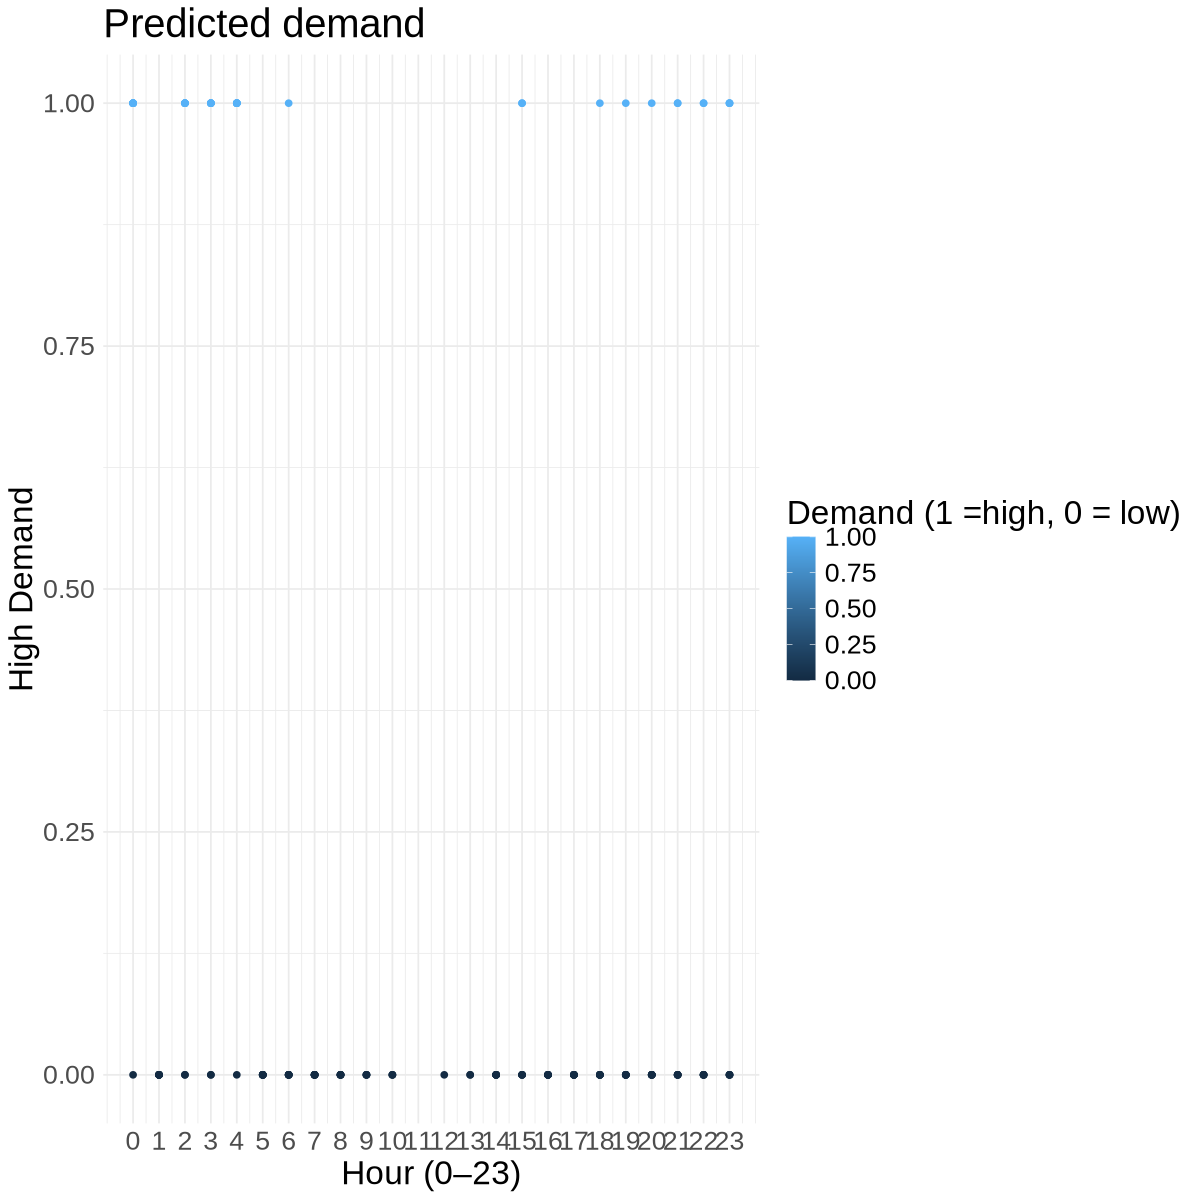

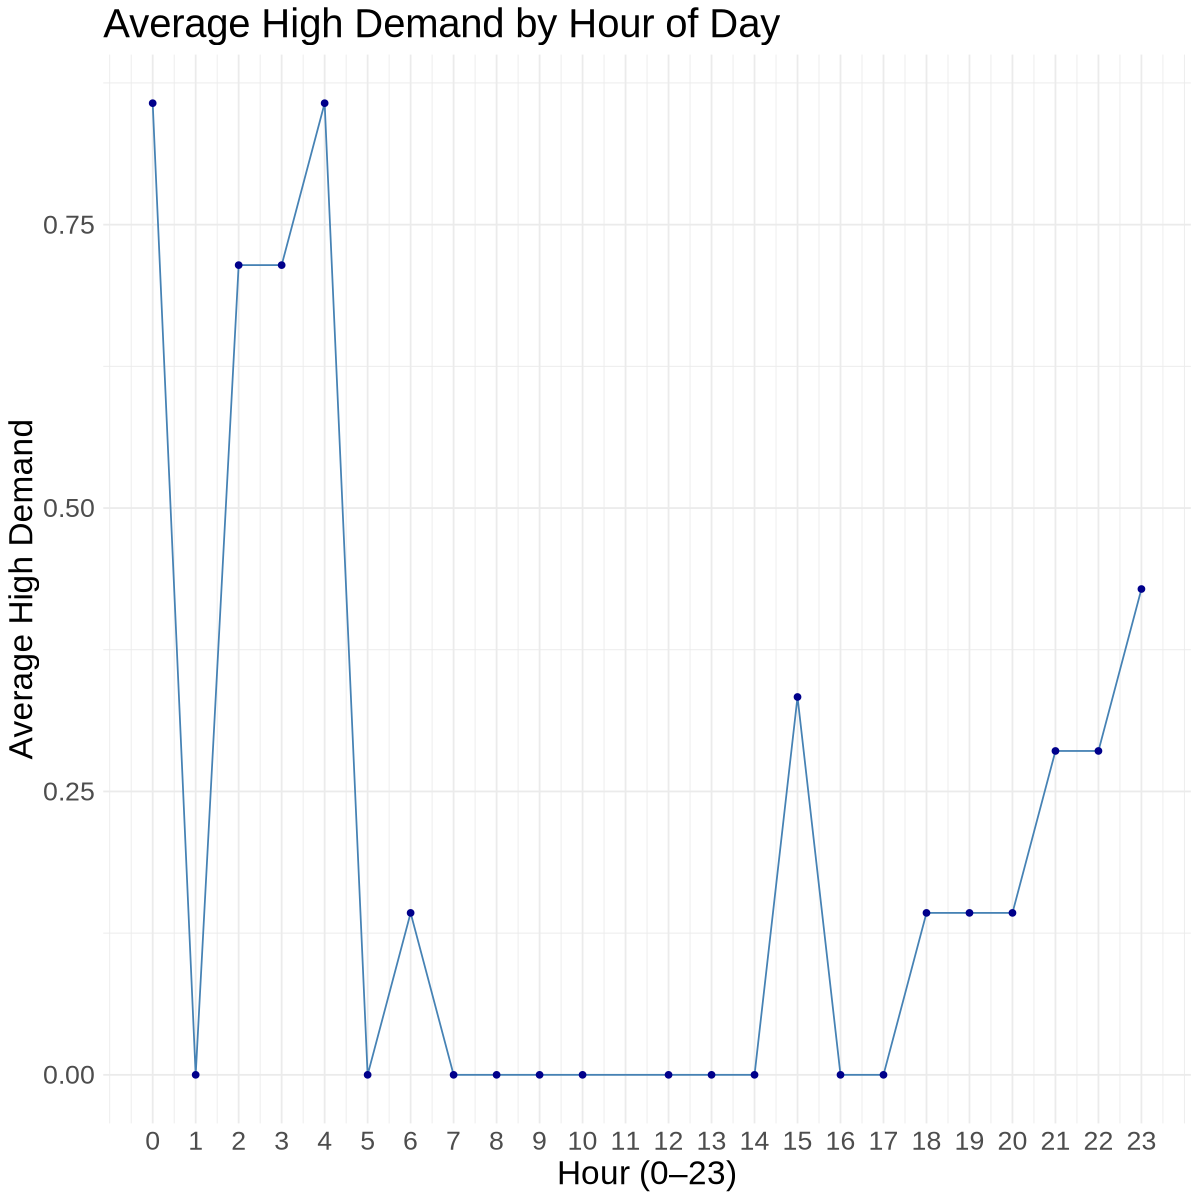

In [7]:
options(repr.plot.height = 10, repr.plot.width = 10)

data_summary_plot <- data_summary |>
  ggplot(aes(x = hour, y = high_demand, color = high_demand)) +
  geom_point() +
  labs(title = "Predicted demand",
       x = "Hour (0–23)", y = "High Demand", color = "Demand (1 =high, 0 = low)") +
  scale_x_continuous(breaks = 0:23) +
  theme_minimal() +
theme(text = element_text(size = 20))
data_summary_plot

data_summary_plot <- data_summary |>
  group_by(hour) |>
  summarise(avg_demand = mean(high_demand, na.rm = TRUE)) |>
  ggplot(aes(x = hour, y = avg_demand)) +
  geom_line(color = "steelblue") +
  geom_point(color = "darkblue") +
  labs(title = "Average High Demand by Hour of Day",
       x = "Hour (0–23)", y = "Average High Demand") +
  scale_x_continuous(breaks = 0:23) +
  theme_minimal() +
theme(text = element_text(size = 20))
data_summary_plot

Convert high_demand into a factor because classification uses a categorical variable as response.

In [8]:
data_summary <- data_summary |>
    mutate(high_demand = as_factor(high_demand))
tail(data_summary)

hour,wday_num,high_demand
<int>,<dbl>,<fct>
23,2,1
23,3,0
23,4,1
23,5,0
23,6,0
23,7,1


Split the data into training and testing sets. Create recipe, model and fit the training data using workflow. Then make prediction on the test set and calculate accuracy, precision, recall and form confusion matrix.

In [9]:
set.seed(2)

data_split <- initial_split(data_summary, prop = 0.8, strata = high_demand)
train_data <- training(data_split)
test_data <- testing(data_split)

knn_recipe <- recipe(high_demand ~ hour, data = train_data) |>
  step_scale(all_predictors()) |> 
  step_center(all_predictors())         

knn_model <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_model(knn_model) |>
  add_recipe(knn_recipe) |>
  fit(data = train_data)

knn_preds <- predict(knn_fit, test_data) |>
  bind_cols(test_data)
  
knn_accuracy <- knn_preds |>
  metrics(truth = high_demand, estimate = .pred_class) |>
  filter(.metric == "accuracy") 

knn_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.75


In [10]:
precision <- knn_preds |>
  precision(truth = high_demand, estimate = .pred_class)
precision

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.7916667


In [11]:
recall <- knn_preds |>
  recall(truth = high_demand, estimate = .pred_class)
recall

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.9047619


In [12]:
confusion <- knn_preds |>
             conf_mat(truth = high_demand, estimate = .pred_class)
confusion

          Truth
Prediction  0  1
         0 19  5
         1  2  2

Now, do 10-fold cross-calidation and find the best k value. Create a tibble for k values from 1 to 10. Then fit the workflow using tuning grid. 

In [13]:
knn_vfold <- vfold_cv(train_data, v = 10, strata = high_demand)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

k_vals <- tibble(neighbors = 1:10)

knn_workflow <- workflow() |>
  add_model(knn_spec) |>
  add_recipe(knn_recipe) 

knn_results <- knn_workflow |>
  tune_grid(resamples = knn_vfold, grid = k_vals) |>
  collect_metrics()

accuracies <- knn_results |>
  filter(.metric == "accuracy")

accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6709091,10,0.03056102,Preprocessor1_Model01
2,accuracy,binary,0.7107576,10,0.02023035,Preprocessor1_Model02
3,accuracy,binary,0.8565152,10,0.03566533,Preprocessor1_Model03
4,accuracy,binary,0.8731818,10,0.03398960,Preprocessor1_Model04
5,accuracy,binary,0.8913636,10,0.02300066,Preprocessor1_Model05
6,accuracy,binary,0.8913636,10,0.02300066,Preprocessor1_Model06
7,accuracy,binary,0.8648485,10,0.02435663,Preprocessor1_Model07
8,accuracy,binary,0.8557576,10,0.02007129,Preprocessor1_Model08
9,accuracy,binary,0.8192424,10,0.02234819,Preprocessor1_Model09


Plot accuracy vs neighbors (k).

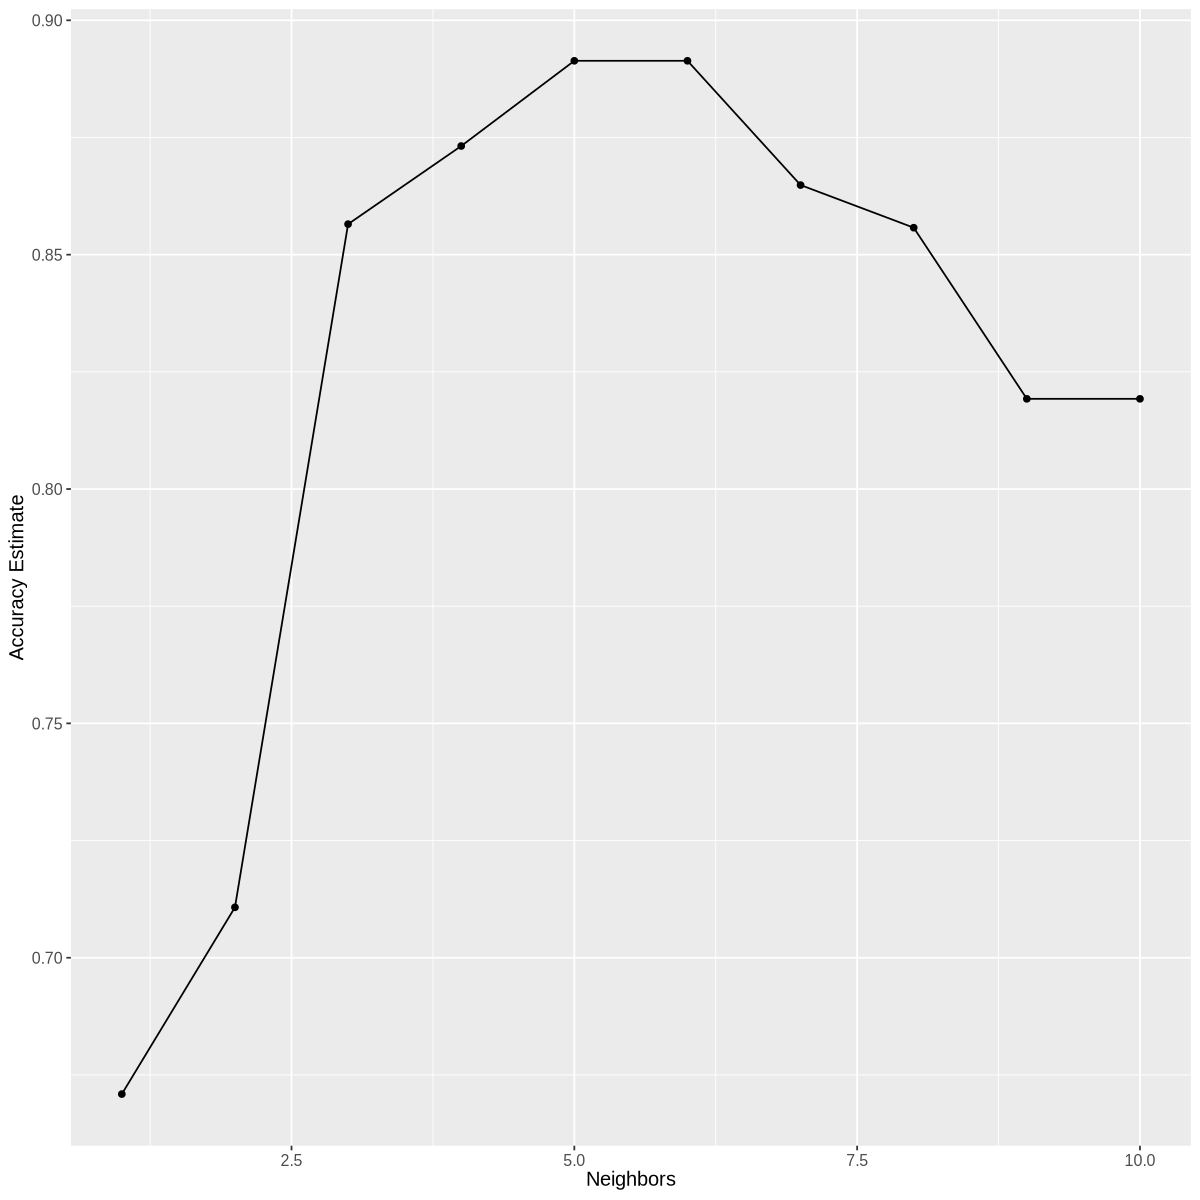

In [14]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))

accuracy_vs_k

Pick best k value from the plot.

In [15]:
best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

[1] 5

Train the model on the best k value for the training data.

In [16]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(knn_recipe) |>
  add_model(knn_spec) |>
  fit(data = train_data)

knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(5L,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1090909
Best kernel: rectangular
Best k: 5

Predict and evaluate the accuracy on test data. Also calculate precision, recall and form confusion matrix.

In [17]:
data_predictions <- predict(knn_fit, test_data) |>
  bind_cols(test_data)

accuracy <- data_predictions |>
  metrics(truth = high_demand, estimate = .pred_class) |>
  filter(.metric == "accuracy")
accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.75


In [18]:
precision_test <- data_predictions |>
  precision(truth = high_demand, estimate = .pred_class)
precision_test

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.7916667


In [19]:
recall_test <- data_predictions |>
  recall(truth = high_demand, estimate = .pred_class)
recall_test

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.9047619


In [20]:
confusion_test <- data_predictions |>
             conf_mat(truth = high_demand, estimate = .pred_class)
confusion_test

          Truth
Prediction  0  1
         0 19  5
         1  2  2

Plot 

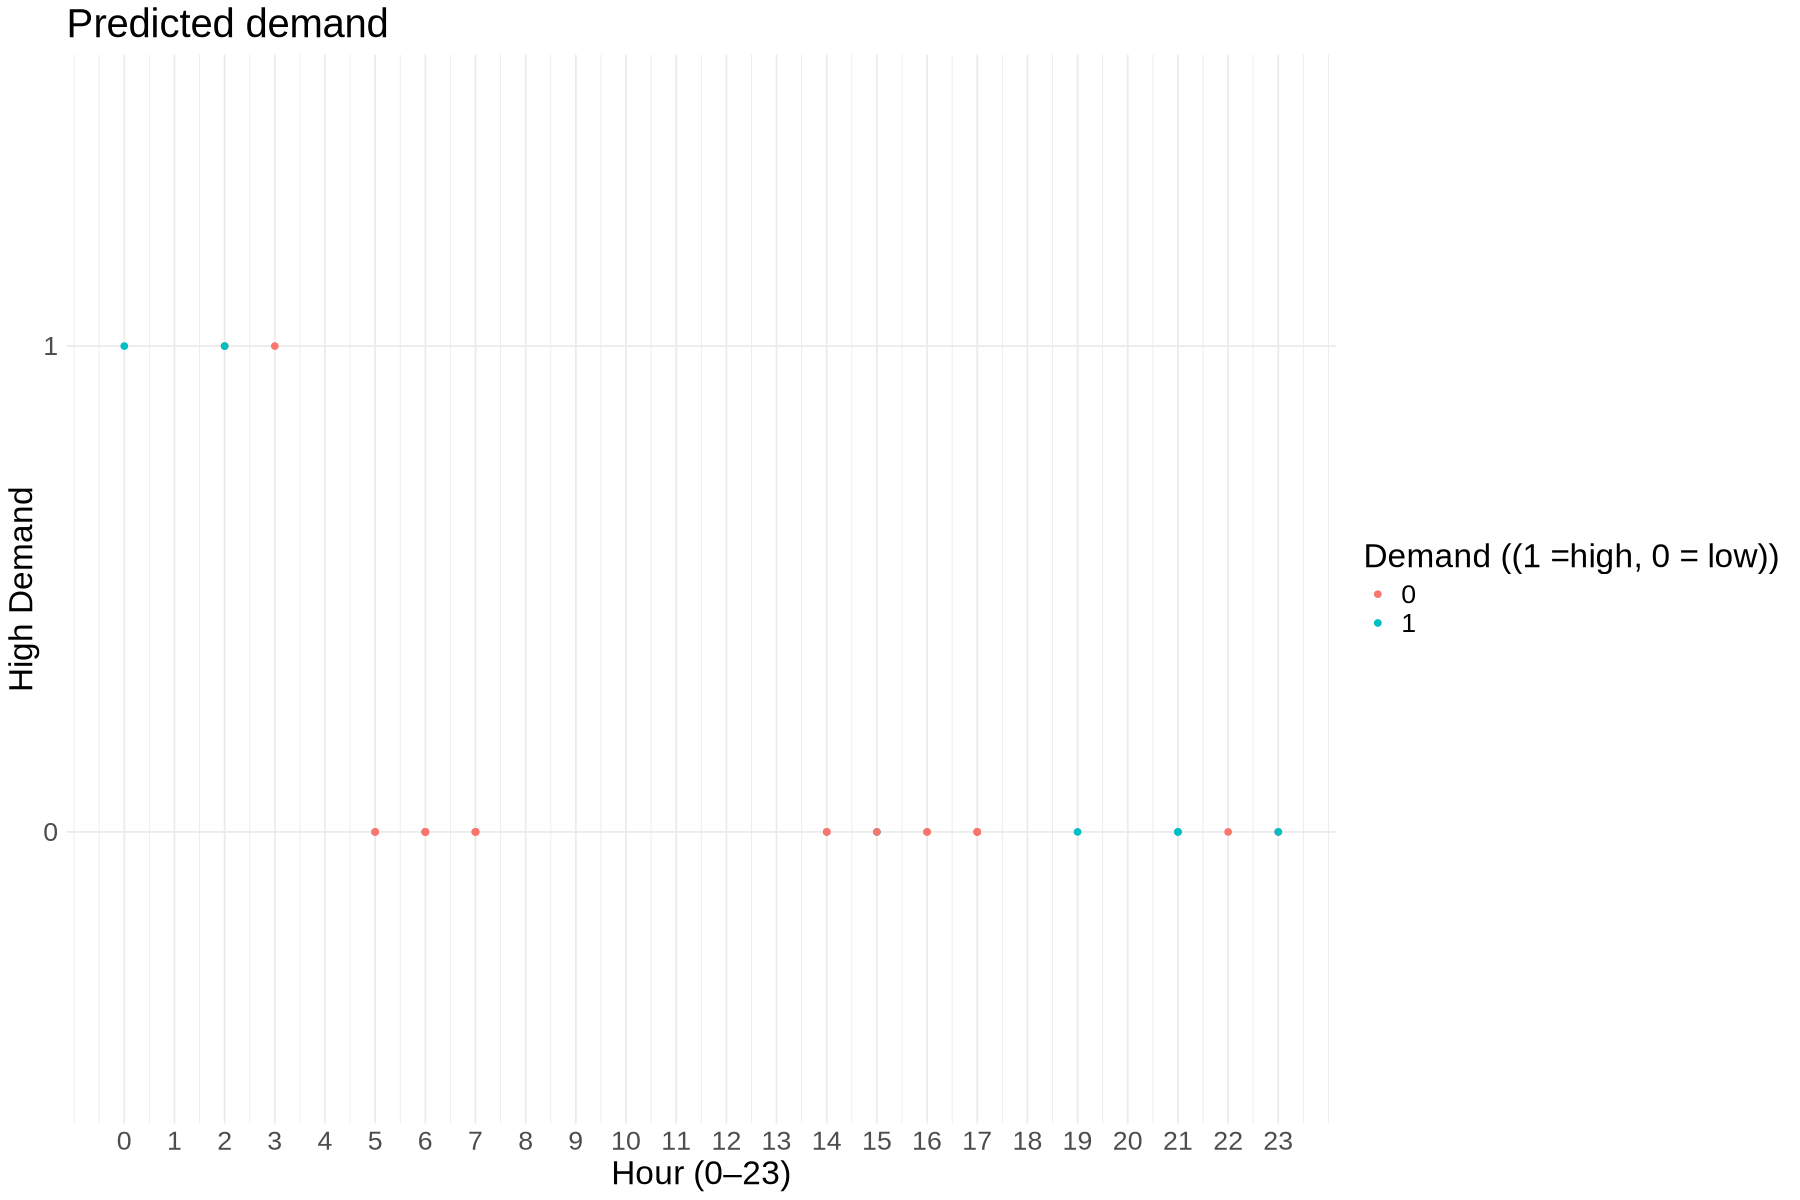

In [22]:
options(repr.plot.height = 10, repr.plot.width = 15)

data_plot <- data_predictions |>
  ggplot(aes(x = hour, y = .pred_class, color = high_demand)) +
  geom_point() +
  labs(title = "Predicted demand",
       x = "Hour (0–23)", y = "High Demand", color = "Demand ((1 =high, 0 = low))") +
  scale_x_continuous(breaks = 0:23) +
  theme_minimal() +
theme(text = element_text(size = 20))
data_plot

## Results and conclusion
The model has 75% accuracy however, the recall and precision for the model is quite high (90% and 79% respectively). High recall means the model actually identifies 90% of the time that this hour is in high demand (large number of players on the server at the same time). Precision tells us that of the times the model predicted high demand, 79% were actually high demands. the accuracy is 75%. Overall, 75% of predictions were correct. But this number can be misleading in imbalanced datasets. For example, if most time periods are low demand, a model could get high accuracy just by guessing "low" often — even if it misses lots of real "high" cases. That’s why precision and recall are often more meaningful.

This model results have meaningful implications for real-world applications, especially in scenarios where anticipating high server demand is critical — such as resource allocation,  right hardware resources, recruiting efforts. A high recall of 90% means that the model is very effective at finding nearly all high-demand periods, which helps avoid missed peaks that could lead to server crashes, lag, or poor user experience. Additionally, the precision of 79% shows that most of the time the model predicts high-demand, it’s correct — reducing the chance of over-allocating resources unnecessarily.

In conclusion, the 75% accuracy of the model indicates moderate overall performance, but the high recall (90%) and strong precision (79%) suggest that it performs very well in identifying and correctly labeling the positive class (high demand). This is especially important if missing positive cases has great consequense which is the case for our model.

## Reference 
Nebel, S., Schneider, S., & Rey, G. D. (2016). Mining learning and crafting scientific experiments: A literature review on the use of Minecraft in education and research. Educational Technology & Society, 19(2), 355–366. https://www.jstor.org/stable/jeductechsoci.19.2.355